In [1]:
#conda install tensorflow-gpu
#pip install gym
#pip install box2d
#pip install pandas
#pip install matplotlib
#pip install opencv-python
#pip install tqdm

In [2]:
seed=1
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED']=str(seed)
import numpy as np
np.random.seed(seed)
import tensorflow
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Convolution2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
from tqdm import tqdm,trange
import gym
from copy import copy , deepcopy
import cProfile
#from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
TanH=tensorflow.keras.layers.Activation('tanh')
Sigmoid=tensorflow.keras.layers.Activation('sigmoid')
#tf.test.is_gpu_available()
#tf.keras.backend.set_floatx('float64')
physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def compute_steering_speed_gyro_abs(_img):
    right_steering = _img[6, 36:46].mean()/255
    left_steering = _img[6, 26:36].mean()/255
    _steering = (right_steering - left_steering + 1.0)/2
    
    l_gyro = _img[6, 46:60].mean()/255
    r_gyro = _img[6, 60:76].mean()/255
    _gyro = (r_gyro - l_gyro + 1.0)/2
    
    
    _speed =_img[:, 0][:-2].mean()/255
    _abs1 = _img[:, 6][:-2].mean()/255
    _abs2 = _img[:, 8][:-2].mean()/255
    _abs3 = _img[:, 10][:-2].mean()/255
    _abs4 = _img[:, 12][:-2].mean()/255
    
    return [_steering, _speed, _gyro, _abs1, _abs2, _abs3, _abs4]
def get_states(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).reshape((img.shape[0],img.shape[1],1))
    sensor_values=compute_steering_speed_gyro_abs(img)
    img=np.array(img[:84,6:-6,:]/255.0,dtype=np.float32)
    return img,sensor_values

In [ ]:

def Actor(n_act,N=8):
    state_1=Input(shape=[84,84,1])
    state_2=Input(shape=[7])
    x = Conv2D(N,strides=2,kernel_size=7,activation='relu')(state_1)
    x = Conv2D(2*N,strides=2,kernel_size=5,activation='relu')(x)
    x = Conv2D(4*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Conv2D(8*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Conv2D(16*N,strides=2,kernel_size=3,activation='relu')(x)
    #x = Conv2D(32*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Flatten()(x)
    x = Concatenate()([x,state_2])
    x = Dense(128, activation='relu')(x)
    #x = Dense(256, activation='relu')(x)
    mean = Dense(n_act)(x)
    mean  = TanH(mean)
    std = Dense(n_act)(x)
    std  = Sigmoid(std)#+10e-10
    actor_model=Model(inputs=[state_1,state_2],outputs=[mean,std])
    return actor_model
    
def Critic(N=8):
    state_1=Input(shape=[84,84,1])
    state_2=Input(shape=[7])
    x = Conv2D(N,strides=2,kernel_size=7,activation='relu')(state_1)
    x = Conv2D(2*N,strides=2,kernel_size=5,activation='relu')(x)
    x = Conv2D(4*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Conv2D(8*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Conv2D(16*N,strides=2,kernel_size=3,activation='relu')(x)
    #x = Conv2D(32*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Flatten()(x)
    x = Concatenate()([x,state_2])
    x = Dense(128, activation='relu')(x)
    #x = Dense(128, activation='relu')(x)
    value = Dense(1)(x)
    critic_model=Model(inputs=[state_1,state_2],outputs=[value])
    return critic_model

class ppo_model():
    def __init__(self):
        self._actor=Actor(n_act)
        self._critic=Critic()
        self._debug = False
        self._actor_opt= Adam(0.001)
        self._critic_opt= Adam(0.001)
        self.value_coef=0.5
        self.entropy_coef=0.01
        self._gamma=0.99
        self._lambda=0.95
        self.clip_epsilon=0.1#0.05
        self._advantage=16
        
    def get_advantages(self,values, masks, rewards):
        target_qvals = []
        for i in range(len(rewards)-self._advantage):
            _values=values[i:i+self._advantage+1]
            _rewards=rewards[i:i+self._advantage]
            _masks=masks[i:i+self._advantage]
            gae = 0
            for j in reversed(range(self._advantage)):
                delta = _rewards[j] + self._gamma * _values[j + 1] * _masks[j] - _values[j]
                gae = delta + self._gamma * self._lambda * _masks[j] * gae
            target_qvals.append(gae + _values[0])
        target_qvals = np.array(target_qvals)
        adv = np.array(target_qvals) - values[:-self._advantage-1]
        return target_qvals, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    
    def _get_advantages(self,values, masks, rewards):
        target_qvals = []
        gae=0
        for i in reversed(range(len(rewards))):
                delta = rewards[j] + self.gamma * values[j + 1] * masks[j] - values[j]
                gae = delta + self._gamma * self._lambda * masks[j] * gae
        target_qvals.append(gae + _values[0])
        target_qvals = np.array(target_qvals)
        adv = np.array(target_qvals) - values[:-self._advantage-1]
        return target_qvals, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    
    def actor_loss(self,mean,std,old_mean,old_std,old_action,advantage_raw):#, rewards, values):
            old_probs = self.get_log_probs(old_action,old_mean,old_std)
            new_probs = self.get_log_probs(old_action,mean,std)
            entropy_loss = self.get_entropy(std)
            ratio = K.exp(new_probs-old_probs)
            p1 = ratio * advantage_raw
            p2 = K.clip(ratio, min_value=1 - self.clip_epsilon, max_value=1 + self.clip_epsilon) * advantage_raw
            actor_loss = K.mean(K.minimum(p1, p2))
            #critic_loss = 0#K.mean(K.square(rewards - values))
            total_loss =   -actor_loss - self.entropy_coef * entropy_loss #* K.mean(-(new_probs * K.log(new_probs + 1e-10)))
            #tf.print('A',tf.reduce_sum(new_probs),tf.reduce_sum(old_probs),'B',tf.reduce_sum(ratio))
            return total_loss

    @tf.function
    def train_actor(self,curr_states,_old_mean,_old_std,_old_actions,_advantage_raw):
             _advantage_raw=tf.cast(_advantage_raw,tf.float32)
             with tf.GradientTape() as tape:
                  mean,std = self._actor(curr_states, training=True)
                  if self._debug ==True :tf.print('1 : train_actor :',tf.reduce_sum(curr_states),tf.reduce_sum(mean),tf.reduce_sum(std))
                  _act_loss = self.actor_loss(mean,std,_old_mean,_old_std,_old_actions,_advantage_raw)
                  gradients = tape.gradient(_act_loss, self._actor.trainable_variables)
                  self._actor_opt.apply_gradients(zip(gradients, self._actor.trainable_variables))
                  #tf.print('actor grad : ',gradients[0])
             return  _act_loss

    @tf.function          
    def critic_loss(self,_values,_target_rewards):
            batch_size=_values.shape[0]
            critic_loss=self.value_coef*2*tf.reduce_sum(tf.square(_target_rewards-_values))/batch_size
            return critic_loss
        
    @tf.function
    def train_critic(self,_states,_target_rewards):
            with tf.GradientTape() as tape:
                _values=self._critic(_states)
                _values=tf.cast(_values,tf.float32)
                _target_rewards=tf.cast(_target_rewards,tf.float32)
                _critic_loss=self.critic_loss(_values,_target_rewards)
                gradients = tape.gradient(_critic_loss, self._critic.trainable_variables)
                self._critic_opt.apply_gradients(zip(gradients, self._critic.trainable_variables))
                #tf.print('critic grad : ',gradients[0])
            return _critic_loss
    @tf.function
    def get_log_probs(self,_actions,mean,std):
        _actions=tf.cast(_actions,tf.float32)
        mean=tf.cast(mean,tf.float32)
        std=tf.cast(std,tf.float32)
        _var = -0.5*((_actions-mean)/(std))**2
        _coef = 1/(std*tf.sqrt(2*np.pi)) 
        
        _probs = _coef*tf.cast(tf.exp(_var),tf.float32)
        #_probs = tf.abs(_probs+ )
        log_probs = tf.math.log(_probs)
        #if _debug==True:
        #    tf.print('2 : log_prob : _var  ',tf.reduce_sum(_var),tf.reduce_sum(_coef),tf.reduce_sum(_actions))
        #    tf.print('2 : log_prob : _probs',tf.reduce_sum(_probs),tf.reduce_sum(log_probs))
        return log_probs
    def get_entropy(self,std):
        entropy = 0.5 * (tf.math.log(2 * np.pi * std ** 2) + 1)
        return entropy




def test_reward():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = get_states(state)
        st_1=K.expand_dims(state[0], 0)
        st_2=K.expand_dims(state[1], 0)
        mean,std = _model._actor([st_1,st_2])
        act=np.random.normal(mean,std)[0]
        next_state, reward, done, _ = env.step(np.clip(mean[0],-1,1))
        #if reward == -100:
        #    reward=-2
        state = next_state
        total_reward += reward
        
    return total_reward
    
image_based = False

env=gym.make('CarRacing-v0')
env.seed(seed)


n_state = env.observation_space.shape[0]
n_act = env.action_space.shape[0]

_model=ppo_model()
ppo_steps = 2048
train_epochs = 16
batch_size = 128
target_reached = False
best_reward = 0
iters = 0
episodes = 1000
adv=_model._advantage
rewards_log=[]
max_reward=0

if not os.path.exists('replay_buffer_ppo'):
       os.mkdir('replay_buffer_ppo') 
for episode in range(episodes):

    
    old_actions = []
    old_probs =[]
    values = []
    masks = []
    rewards = []
    old_means = []
    old_stds  = []
    state_input = None
    sum_reward=0
    sum_reward_log=0
    state = env.reset()
    state=get_states(state)
    for itr in trange(ppo_steps+adv):
        st_1 = K.expand_dims(state[0], 0)
        st_2 = K.expand_dims(state[1], 0)
        mean,std = _model._actor([st_1,st_2])
        q_value  = _model._critic([st_1,st_2])
        action = np.random.normal(mean,std)[0]
        #prob=get_log_probs(action,mean,std)
        observation, reward, done, info = env.step(np.clip(action,-1,1))
        state=get_states(observation)
        #if reward == -100:
        #    reward=-2
        #print('itr: ' + str(itr) + ', action=' + str(action) + ', reward=' + str(reward) + ', q val=' + str(q_value.numpy()))
        mask = not done
        with open('replay_buffer_ppo/'+str(itr)+'.pkl','wb') as file:
                      pickle.dump(state,file)
        #_curr_states_1.append(state[0])
        #_curr_states_2.append(state[1])
        old_actions.append(action)
        #old_probs.append(prob)
        old_means.append(mean)
        old_stds.append(std)
        values.append(q_value)
        masks.append(mask)
        rewards.append(np.clip(reward,-.01,1000))
        sum_reward+=reward

        state = get_states(observation)
        if done:
            sum_reward_log=copy(sum_reward)
            sum_reward=0
            state=env.reset()
            state = get_states(state)
        
    st_1=K.expand_dims(state[0], 0)
    st_2=K.expand_dims(state[1], 0)
    q_value = _model._critic([st_1,st_2])
    values.append(q_value)
    #_curr_states_1=np.array(_curr_states_1)#.reshape(-1,n_state)
    #_curr_states_2=np.array(_curr_states_2)#.reshape(-1,n_state)
    _old_actions=np.array(old_actions).reshape(-1,n_act)
    _old_means=np.array(old_means).reshape(-1,n_act)
    _old_stds=np.array(old_stds).reshape(-1,n_act)
    _values=np.array(values).reshape(-1,1)
    _rewards=np.array(rewards).reshape(-1,1)
    _masks  = np.array(masks).reshape(-1,1)
    
    _target_qvals, _advantages = _model.get_advantages(_values, _masks, _rewards)
    for _ in range(train_epochs):
        no_of_batch=(ppo_steps//batch_size)
        index=np.arange(ppo_steps)
        np.random.shuffle(index)
        for batch in range(no_of_batch):
            _ind=index[batch*batch_size:(batch+1)*batch_size]
            
            _curr_states_1 = []
            _curr_states_2 = []
            for __ind in _ind:
                with open('replay_buffer_ppo/'+str(__ind)+'.pkl','rb') as file:
                    state= pickle.load(file)
                    _curr_states_1.append(state[0])
                    _curr_states_2.append(state[1])
            _curr_states_1=np.array(_curr_states_1)
            _curr_states_2=np.array(_curr_states_2)
            
            _model.train_actor([_curr_states_1,_curr_states_2],_old_means[_ind],_old_stds[_ind],_old_actions[_ind],_advantages[_ind])
            _model.train_critic([_curr_states_1,_curr_states_2],_target_qvals[_ind])                            
    #del _curr_states_1,_curr_states_2
    avg_reward=0
    for _ in range(5):
        avg_reward += test_reward()
    avg_reward/=5
    print('episode :',episode,'reward :',sum_reward_log)   
    print('total test reward=' + str(avg_reward))
    if avg_reward >=max_reward:
        _model._actor.save_weights('ppo_best_actor_car.hdf5')
        _model._critic.save_weights('ppo_best_critic_car'+'.hdf5')
        best_eps=episode
        max_reward = avg_reward
    rewards_log.append([sum_reward_log,avg_reward])
    iters += 1
    

env.close()
plt.plot(rewards_log)

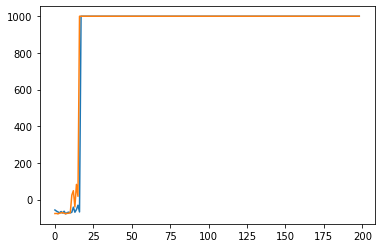

In [5]:
plt.plot(rewards_log)

In [7]:
sum_reward_log

999.8000000000031

In [ ]:
def test_reward():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = get_states(state)
        st_1=K.expand_dims(state[0], 0)
        st_2=K.expand_dims(state[1], 0)
        mean,std = _model._actor([st_1,st_2])
        act=np.random.normal(mean,std)[0]
        print(mean,std,act)
        next_state, reward, done, _ = env.step(mean[0])
        if reward == -100:
            reward=-2
        state = next_state
        total_reward += reward
        
    return total_reward
test_reward()

In [ ]:
#_model._actor.save_weights('ppo-1000.hdf5')
import pickle
f=open('ppo-car-loss.pkl','wb')
pickle.dump(rewards_log,f)
f.close()

In [ ]:
#_model._actor.load_weights('ppo-1000.hdf5')

In [ ]:
plt.plot(old_actions)

In [ ]:
plt.plot(_old_means)
plt.show()
plt.plot(_old_stds)

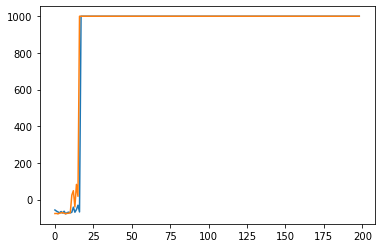

In [8]:
plt.plot(rewards_log)
plt.savefig('car-ppo.png')

In [1]:
import os
seed=1
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED']=str(seed)
import numpy as np
np.random.seed(seed)
import tensorflow
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Convolution2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
from tqdm import tqdm,trange
import gym
from copy import copy , deepcopy
import cProfile
#from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
TanH=tensorflow.keras.layers.Activation('tanh')
Sigmoid=tensorflow.keras.layers.Activation('sigmoid')
#tf.test.is_gpu_available()
#tf.keras.backend.set_floatx('float64')
physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
try:os.mkdir('car_ppo')
except:0

In [2]:
def Actor(n_act,N=8):
    state_1=Input(shape=[84,84,1])
    state_2=Input(shape=[7])
    x = Conv2D(N,strides=2,kernel_size=7,activation='relu')(state_1)
    x = Conv2D(2*N,strides=2,kernel_size=5,activation='relu')(x)
    x = Conv2D(4*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Conv2D(8*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Conv2D(16*N,strides=2,kernel_size=3,activation='relu')(x)
    #x = Conv2D(32*N,strides=2,kernel_size=3,activation='relu')(x)
    x = Flatten()(x)
    x = Concatenate()([x,state_2])
    x = Dense(128, activation='relu')(x)
    #x = Dense(256, activation='relu')(x)
    mean = Dense(n_act)(x)
    mean  = TanH(mean)
    std = Dense(n_act)(x)
    std  = Sigmoid(std)#+10e-10
    actor_model=Model(inputs=[state_1,state_2],outputs=[mean,std])
    return actor_model
    
def compute_steering_speed_gyro_abs(_img):
    right_steering = _img[6, 36:46].mean()/255
    left_steering = _img[6, 26:36].mean()/255
    _steering = (right_steering - left_steering + 1.0)/2
    
    l_gyro = _img[6, 46:60].mean()/255
    r_gyro = _img[6, 60:76].mean()/255
    _gyro = (r_gyro - l_gyro + 1.0)/2
    
    
    _speed =_img[:, 0][:-2].mean()/255
    _abs1 = _img[:, 6][:-2].mean()/255
    _abs2 = _img[:, 8][:-2].mean()/255
    _abs3 = _img[:, 10][:-2].mean()/255
    _abs4 = _img[:, 12][:-2].mean()/255
    
    return [_steering, _speed, _gyro, _abs1, _abs2, _abs3, _abs4]
def get_states(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).reshape((img.shape[0],img.shape[1],1))
    sensor_values=compute_steering_speed_gyro_abs(img)
    img=np.array(img[:84,6:-6,:]/255.0,dtype=np.float32)
    return img,sensor_values

env = gym.make('CarRacing-v0')
env.seed(seed)
n_act=env.action_space.shape[0]
n_state=env.observation_space.shape[0]
state=env.reset()
_actor=Actor(n_act)
_state=get_states(state)
st_1 = K.expand_dims(_state[0], 0)
st_2 = K.expand_dims(_state[1], 0)
_actor([st_1,st_2])
_actor.load_weights('ppo_best_actor_car.hdf5')

Track generation: 1055..1332 -> 277-tiles track


In [3]:
get_states(state)[0].shape

(84, 84, 1)

In [8]:
_state,rwd,ter,info=env.step(action)
action,rwd,ter

(array([ 0.03056718,         nan, -0.36565146], dtype=float32),
 -0.10000000000002274,
 True)

In [9]:
_state=env.reset()
state=get_states(_state)
i=0
ter_count=0
while True:
    st_1 = K.expand_dims(state[0], 0)
    st_2 = K.expand_dims(state[1], 0)
    mean,std=_actor([st_1,st_2])
    action=np.clip(mean[0],-1,1)
    action=np.nan_to_num(action)
    _state,rwd,ter,info=env.step(action)
    state=get_states(_state)
    img=env.render('rgb_array')
    cv2.imwrite('car_ppo/'+str(i)+'.jpg',img)
    i+=1
    if ter==True:
            ter_count+=1
            _state=env.reset()
            state=get_states(_state)
    if ter_count==5:
             break

Track generation: 1172..1469 -> 297-tiles track
Track generation: 1136..1424 -> 288-tiles track
Track generation: 1060..1329 -> 269-tiles track


KeyboardInterrupt: 

In [ ]:
env.close()